In [9]:
# uv add jupyter ipykernel
#uv add ultralytics torch torchvision opencv-python pandas matplotlib

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.windows import Window

In [11]:
def safe_explore_tif(tif_path):
    """Safely explore the TIF file with error handling"""
    try:
        with rasterio.open(tif_path) as src:
            print("=== Basic File Information ===")
            print(f"Shape: {src.shape}")
            print(f"Number of bands: {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            print(f"Data type: {src.dtypes[0]}")
    except Exception as e:
        print(f"Error reading file: {e}")

In [12]:
# First, let's see if we can at least get basic info
tif_path = '../01_raw_data/Sample-drone-data-copy.tif'
safe_explore_tif(tif_path)

=== Basic File Information ===
Shape: (5603, 9424)
Number of bands: 5
CRS: EPSG:4326
Bounds: BoundingBox(left=103.285335865, bottom=2.15741308, right=103.299934651, top=2.166144533)
Data type: uint16



=== TESTING BAND COMBINATIONS FOR NATURAL COLORS ===
combo_321 (bands (3, 2, 1)): Green/Red ratio = 0.00
combo_321 (bands (3, 2, 1)): Green/Red ratio = 0.71
combo_321 (bands (3, 2, 1)): Green/Red ratio = 0.71
combo_231 (bands (2, 3, 1)): Green/Red ratio = 0.00
combo_231 (bands (2, 3, 1)): Green/Red ratio = 1.40
combo_231 (bands (2, 3, 1)): Green/Red ratio = 1.40
combo_123 (bands (1, 2, 3)): Green/Red ratio = 0.00
combo_123 (bands (1, 2, 3)): Green/Red ratio = 0.87
combo_123 (bands (1, 2, 3)): Green/Red ratio = 0.87
combo_432 (bands (4, 3, 2)): Green/Red ratio = 0.00
combo_432 (bands (4, 3, 2)): Green/Red ratio = 1.00
combo_432 (bands (4, 3, 2)): Green/Red ratio = 1.00


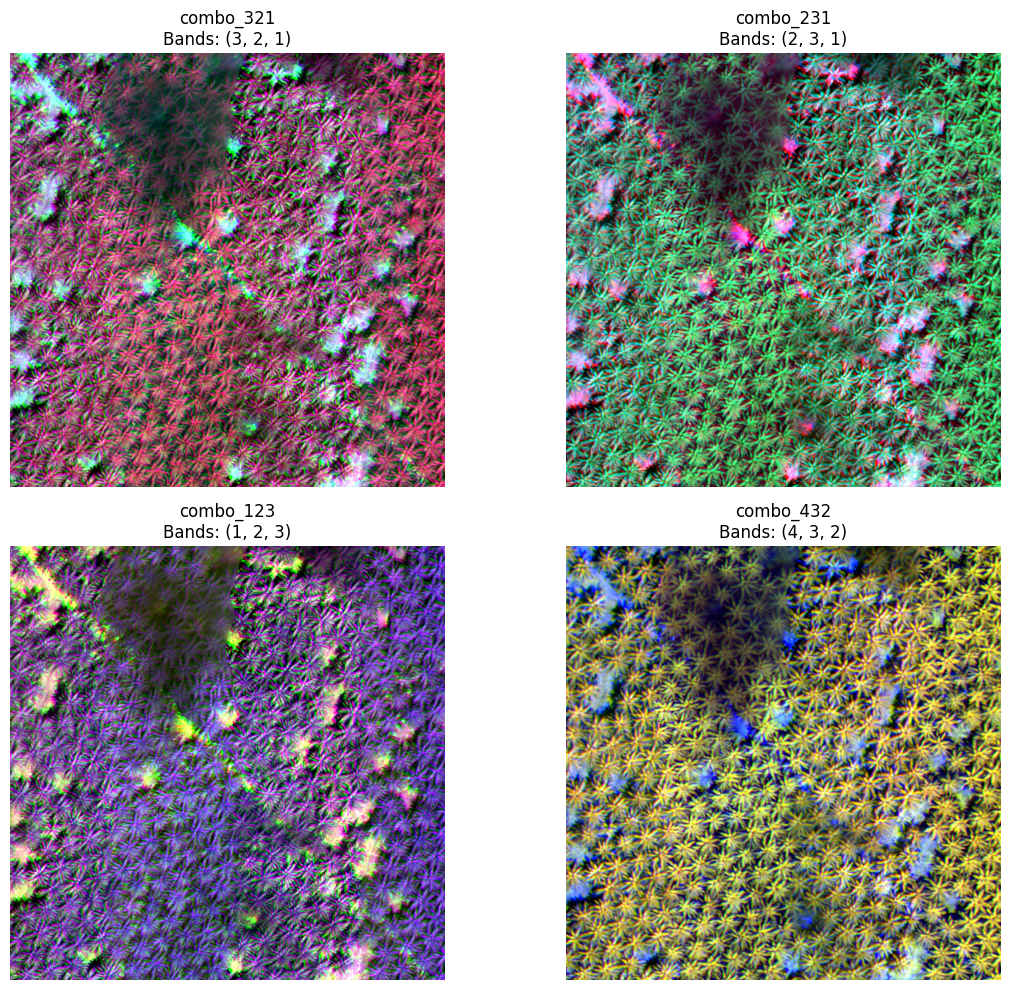

In [13]:
def test_band_combinations(tif_path):
    """Test different band combinations to find the one that gives
    natural colors"""
    print("\n=== TESTING BAND COMBINATIONS FOR NATURAL COLORS ===")
    band_combinations = {
    'combo_321': (3, 2, 1), # What we tried before (gave red)
    'combo_231': (2, 3, 1), # Alternative 1 (should give green)
    'combo_123': (1, 2, 3), # Alternative 2
    'combo_432': (4, 3, 2), # False color
    }

    with rasterio.open(tif_path) as src:
        # Read a small test area
        test_window = Window(0, 0, 1000, 1000)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        for idx, (combo_name, band_combo) in enumerate(band_combinations.items()):

            try:
                # Read the bands
                test_data = src.read(band_combo, window=test_window)
                # Convert to 8-bit for display
                test_8bit = np.zeros_like(test_data, dtype=np.uint8)
                for i in range(3):
                    band = test_data[i]
                    p2, p98 = np.percentile(band, (2, 98))
                    if p98 > p2: band_stretched = np.clip((band - p2) / (p98 - p2) * 255, 0, 255)
                    test_8bit[i] = band_stretched.astype(np.uint8)
                    # Display
                    rgb_display = np.transpose(test_8bit, (1, 2, 0))
                    axes[idx].imshow(rgb_display)
                    axes[idx].set_title(f'{combo_name}\nBands: {band_combo}')
                    axes[idx].axis('off')
                    # Color analysis
                    green_ratio = rgb_display[:,:,1].mean() / (rgb_display[:,:,0].mean() + 0.001)
                    print(f"{combo_name} (bands {band_combo}): Green/Red ratio = {green_ratio:.2f}")

            except Exception as e:
                print(f"Error with {combo_name}: {e}")
                axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()
        return band_combinations
    
band_combos = test_band_combinations(tif_path)


In [14]:
def create_final_rgb_composite(input_path, output_path, band_combination=(2, 3, 1)):
    """Create RGB composite with correct band ordering for natural
    colors"""
    print(f"\n=== CREATING FINAL RGB COMPOSITE ===")
    print(f"Using band combination: {band_combination} for natural colors")

    with rasterio.open(input_path) as src:
        height, width = src.height, src.width
        print(f"Processing image: {width}x{height}")
        # Create output file
        profile = src.profile
        profile.update({
        'count': 3,
        'dtype': 'uint16',
        'driver': 'GTiff'
        })
        with rasterio.open(output_path, 'w', **profile) as dst:
            processed_rows = 0

            # Process in chunks to handle corruption
            for start_row in range(0, height, 1000):
                end_row = min(start_row + 1000, height)
                current_chunk_height = end_row - start_row

                try: 
                    # Read the chunk with CORRECT band order (2,3,1)
                    chunk_data = []
                    for band_idx in band_combination:  
                        try:
                            window = Window(0, start_row, width, current_chunk_height)
                            band_chunk = src.read(band_idx, window=window)
                            chunk_data.append(band_chunk)
                        except Exception as e:
                            print(f"Error reading band {band_idx} at row {start_row}: {e}") 

                            # Create empty data for corrupted areas
                            empty_chunk = np.zeros((current_chunk_height, width), dtype=np.uint16)
                            chunk_data.append(empty_chunk)

                    # Stack into RGB and write
                    rgb_chunk = np.stack(chunk_data, axis=0)
                    dst.write(rgb_chunk, window=Window(0, start_row, width, current_chunk_height))

                    processed_rows += current_chunk_height
                    print(f"Processed rows: {processed_rows}/{height} ({processed_rows/height*100:.1f}%)")

                except Exception as e:
                    print(f"Error processing chunk at row {start_row}:{e}")

                    # Write zeros for corrupted chunks
                    empty_chunk = np.zeros((3, current_chunk_height, width), dtype=np.uint16)
                    dst.write(empty_chunk, window=Window(0, start_row, width, current_chunk_height))
                    processed_rows += current_chunk_height

    print(f"RGB composite saved to: {output_path}")
    return output_path

In [ ]:
# Create the final RGB composite with correct colors
rgb_path = create_final_rgb_composite(tif_path,'/content/rgb_final_correct.tif', band_combination=(2, 3, 1))

In [ ]:
def convert_to_8bit_final(input_path, output_path):
    """Convert 16-bit imagery to 8-bit for YOLO model with optimal
    contrast"""
    print(f"\n=== CONVERTING TO 8-BIT FOR MODEL TRAINING ===")